In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime, timedelta

In [3]:
cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv("novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv")
global_population_df = pd.read_csv("population_data.csv")

In [4]:
curr_glob_pop_df = global_population_df[['Country Name', 'Series Name', '2020 [YR2020]']]
curr_glob_pop_df = curr_glob_pop_df[curr_glob_pop_df['Series Name'] == 'Population, total'][['Country Name', '2020 [YR2020]']]

In [5]:
cols = cases_df.keys()
dates = cases_df.loc[:, cols[4]:cols[-1]].keys()
date_format = "%m/%d/%y"

In [6]:
def get_initial_date(df, country_name):
    country_cases_df = df[df['Country/Region'] == country_name]
    for date in dates:
        if country_cases_df[date].any() != 0:
            return date
    return dates[0]

In [7]:
def shift_df(df, country_name, initial_date):
    return df[df['Country/Region'] == country_name].loc[:, initial_date:cols[-1]]

In [8]:
def get_days_since(shifted_df, initial_date):
    if initial_date == None:
        return np.array(range((datetime.strptime(dates[len(dates) - 1], date_format) - 
                  datetime.strptime(dates[0], date_format)).days + 1)).reshape(-1, 1)
    else:
        return np.array(range((datetime.strptime(dates[len(dates) - 1], date_format) - 
                  datetime.strptime(initial_date, date_format)).days + 1)).reshape(-1, 1)

In [9]:
def get_agg_cases_df(df):
    return df.aggregate("sum")

In [10]:
def get_case_numbers(agg_cases_df):
    return agg_cases_df.values.reshape(-1, 1)

In [11]:
def get_case_numbers_per_capita(agg_case_numbers, country_name):
    country_pop = curr_glob_pop_df[curr_glob_pop_df['Country Name'] == country_name]['2020 [YR2020]'].values[0]
    return list(map(lambda x: x / country_pop, agg_case_numbers))

In [12]:
italy_initial_date = get_initial_date(cases_df, "Italy")
italy_shifted_df = shift_df(cases_df, "Italy", italy_initial_date)
italy_agg_cases = get_agg_cases_df(italy_shifted_df)

In [13]:
italy_days_since_start = get_days_since(italy_agg_cases, italy_initial_date)
italy_case_numbers = get_case_numbers(italy_agg_cases)

In [14]:
italy_poly = PolynomialFeatures(degree=5)
italy_reg = LinearRegression(fit_intercept=False, normalize=True)
italy_reg.fit(italy_poly.fit_transform(italy_days_since_start), italy_case_numbers)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

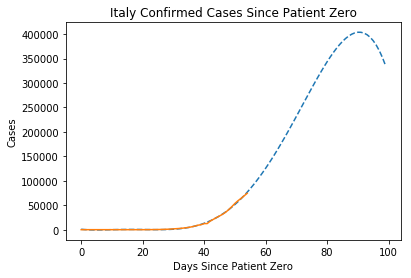

In [15]:
plt.title("Italy Confirmed Cases Since Patient Zero")
plt.ylabel("Cases")
plt.xlabel("Days Since Patient Zero")
plt.plot(range(100), italy_reg.predict(italy_poly.fit_transform(np.array(range(100)).reshape(-1, 1))), linestyle='dashed')
plt.plot(italy_days_since_start, italy_case_numbers)
plt.show()

In [16]:
us_initial_date = get_initial_date(cases_df, "US")
us_shifted_df = shift_df(cases_df, "US", us_initial_date)
us_agg_cases = get_agg_cases_df(us_shifted_df)

In [17]:
us_days_since_start = get_days_since(us_agg_cases, us_initial_date)
us_case_numbers = get_case_numbers(us_agg_cases)

In [18]:
us_poly = PolynomialFeatures(degree=5)
us_reg = LinearRegression(fit_intercept=False, normalize=True)
us_reg.fit(us_poly.fit_transform(us_days_since_start), us_case_numbers)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [19]:
us_hundred_day_pred = us_reg.predict(us_poly.fit_transform(np.array(range(100)).reshape(-1, 1)))

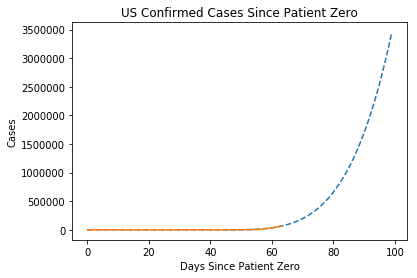

In [20]:
plt.title("US Confirmed Cases Since Patient Zero")
plt.ylabel("Cases")
plt.xlabel("Days Since Patient Zero")
plt.plot(range(100), us_hundred_day_pred, linestyle='dashed')
plt.plot(us_days_since_start, us_case_numbers)
plt.show()

In [21]:
sample_countries = ["US", "Finland", "Panama", "Croatia", "Malaysia", "Slovakia", "Romania", "Lithuania", "Hungary", "Spain", "Vietnam", "New Zealand", "Poland"]

In [22]:
X = []
y = []
sample_weights = []
for country in sample_countries:
    initial_date = get_initial_date(cases_df, country)
    shifted_df = shift_df(cases_df, country, initial_date)
    agg_cases = get_agg_cases_df(shifted_df)
    days_since_start = get_days_since(agg_cases, initial_date)
    case_numbers = get_case_numbers(agg_cases)
    if country == "US":
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, "United States")
        weight = 2
    elif country == "Slovakia":
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, "Slovak Republic")
        weight = 1
    else:
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, country)
        weight = 1
    X.extend(days_since_start)
    y.extend(case_num_per_capita)
    for _ in days_since_start:
        sample_weights.append(weight)

In [23]:
sampled_us_poly = PolynomialFeatures(degree=7)
sampled_us_reg = LinearRegression(fit_intercept=False, normalize=True)
sampled_us_reg.fit(sampled_us_poly.fit_transform(X), y, sample_weight=sample_weights)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [24]:
sampled_us_hundred_day_pred = sampled_us_reg.predict(sampled_us_poly.fit_transform(np.array(range(100)).reshape(-1, 1)))

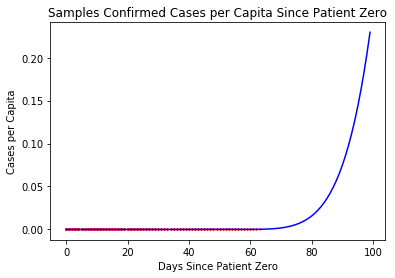

In [25]:
plt.title("Samples Confirmed Cases per Capita Since Patient Zero")
plt.ylabel("Cases per Capita")
plt.xlabel("Days Since Patient Zero")
plt.plot(range(100), sampled_us_hundred_day_pred, c='b')
plt.scatter(X, y, s=1, c='r')
plt.show()

In [26]:
sampled_us_hundred_day_pred[(len(get_days_since(us_shifted_df, us_initial_date)) - 1)] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]

array([ 53876.60542604])

In [27]:
us_agg_cases[(len(get_days_since(us_shifted_df, us_initial_date)) - 1)]

65778

In [28]:
today_pred = sampled_us_hundred_day_pred[(datetime.now() - datetime.strptime(us_initial_date, date_format)).days] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]
tom_pred = sampled_us_hundred_day_pred[(datetime.now() - datetime.strptime(us_initial_date, date_format)).days + 1] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]

In [29]:
print("Today's Prediction: " + str(today_pred))
print("Tomorrow's Prediction: " + str(tom_pred))

Today's Prediction: [ 53876.60542604]
Tomorrow's Prediction: [ 79474.83430553]


In [30]:
deaths_X = []
deaths_y = []
deaths_sample_weights = []
us_agg_deaths = []
us_first_death_date = None
us_days_since_first_death = float("inf")
for country in sample_countries:
    initial_date = get_initial_date(deaths_df, country)
    shifted_df = shift_df(deaths_df, country, initial_date)
    agg_cases = get_agg_cases_df(shifted_df)
    days_since_start = get_days_since(agg_cases, initial_date)
    case_numbers = get_case_numbers(agg_cases)
    if country == "US":
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, "United States")
        weight = 2
        us_agg_deaths = case_numbers
        us_first_death_date = initial_date
        us_days_since_first_death = len(days_since_start) - 1
    elif country == "Slovakia":
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, "Slovak Republic")
        weight = 1
    else:
        case_num_per_capita = get_case_numbers_per_capita(case_numbers, country)
        weight = 1
    deaths_X.extend(days_since_start)
    deaths_y.extend(case_num_per_capita)
    for _ in days_since_start:
        deaths_sample_weights.append(weight)

In [43]:
us_deaths_poly = PolynomialFeatures(degree=7)
us_deaths_reg = LinearRegression(fit_intercept=False, normalize=True)
us_deaths_reg.fit(us_deaths_poly.fit_transform(deaths_X), deaths_y, sample_weight=deaths_sample_weights)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [44]:
us_deaths_hundred_day_pred = us_deaths_reg.predict(us_deaths_poly.fit_transform(np.array(range(100)).reshape(-1, 1)))

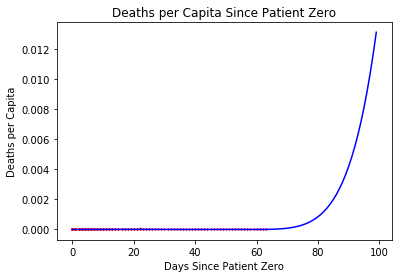

In [45]:
plt.title("Deaths per Capita Since Patient Zero")
plt.ylabel("Deaths per Capita")
plt.xlabel("Days Since Patient Zero")
plt.plot(range(100), us_deaths_hundred_day_pred, c='b')
plt.scatter(deaths_X, deaths_y, s=1, c='r')
plt.show()

In [46]:
us_deaths_hundred_day_pred[(len(get_days_since(us_shifted_df, us_initial_date)) - 1)] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]

array([ 723.11307535])

In [47]:
us_agg_deaths[us_days_since_first_death - 1]

array([706])

In [48]:
today_death_pred = us_deaths_hundred_day_pred[(datetime.now() - datetime.strptime(us_first_death_date, date_format)).days] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]
tom_death_pred = us_deaths_hundred_day_pred[(datetime.now() - datetime.strptime(us_first_death_date, date_format)).days + 1] * curr_glob_pop_df[curr_glob_pop_df['Country Name'] == 'United States']['2020 [YR2020]'].values[0]

In [49]:
print("Today's Prediction: " + str(today_death_pred))
print("Tomorrow's Prediction: " + str(tom_death_pred))

Today's Prediction: [ 1753.39964949]
Tomorrow's Prediction: [ 1587.13131303]
